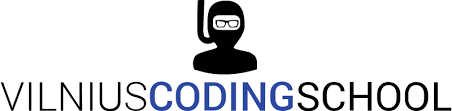

 DARBO APRAŠAS


Pavadinimas:          Duomenų Analitikos kursų baigiamasis darbas
Studentas:            Gediminas Mickevičius
Vieta:			      Vilnius Coding School
Data:			      2021-12-07




Analizės tema:        Finansinių paslaugų gavėjo tipo (asm.duomenų) koreliacija su įsipareigojimų vykdymo kokybe

Tikslai:		      - Nustatyti kokie kliento profilio parametrai ar jų kombinacijos didina nemokumo riziką
			          - Patvirtinti arba paneigti, kad: 
				          a) "gruodžio, bei sausio mėnesį dažniau grąžinamos skolos" 
				          b) "vyresnės moterys pareigingiau vykdo fin.įsipareigojimus"
				          c) "vedę vyrai rečiau tampa nemokiais" 
				      - Naudojantis Python SCLEARN moduliu sukurti potencialaus kliento mokumo prognozavimo įrankį

Duomenų šaltinis:	  Realios lietuviškos vartojimo kreditų rinkos bedrovės "nuasmeninti" duomenys, 
                      ( 2x .XLSX,  1x.CSV (>1 mln. rows)) 


   

Turinys:
(Planas_A-B)

1. Duomenų struktūros, ryšių, kiekybės ir kokybės analizė   	(Python)
2. Duomenų semantikos ir pragmatikos analizė 		            (Tableau)
3. Importavimas iš CSV į MySQL su Python pagalba 		        
   (>1mln įrašų 1 lentelė apie klientų mokėjimus)               (MySQL)
4. Duomenų agregavimas SQL'e (group by, count, sum, max, avg)	(MySQL)
5. Apjungtų duomenų analizė su Tabelau 				            (Tableau)
---------------------
(Planas_A+B)
6. Apjungtų duomenų analizė su Python				            (Python)
7. Kliento mokumo prognozavimas					                (Python)


# Duomenų struktūros, ryšių, kiekybės ir kokybės analizė   	(Python)

In [3]:
import numpy as np
import pandas as pd

In [4]:
imokos = pd.read_csv('C:\imokos.csv')         # > 1 mln rows read in 1.3s ! 

In [15]:
imokos                                       # ziurim ka turim... 1,16 mln

,Loan ID,Payment date,Repayment date,Type,State,Amount,Pending amount
0,L-00016375,2018-09-07,2018-09-07,paskolos dalis,apmoketa laiku,11.42,0.0
1,L-00016375,2018-09-07,2018-09-07,palukanos,apmoketa laiku,19.17,0.0
2,L-00016375,2018-10-07,2018-10-08,paskolos dalis,apmoketa laiku,11.70,0.0
3,L-00016375,2018-10-07,2018-10-08,palukanos,apmoketa laiku,18.95,0.0
4,L-00016375,2018-11-07,2018-11-07,paskolos dalis,apmoketa laiku,11.99,0.0
...,...,...,...,...,...,...,...
1160063,L-58579736,2021-11-24,2021-11-24,paskolos dalis,apmoketa laiku,4740.00,0.0
1160064,L-11851533,2021-11-16,2021-11-16,paskolos dalis,apmoketa laiku,4500.00,0.0
1160065,L-88953684,2021-10-04,2021-10-04,paskolos dalis,apmoketa laiku,10800.00,0.0
1160066,L-52558653,2021-11-15,2021-11-15,paskolos dalis,apmoketa laiku,3295.00,0.0


In [21]:
print(imokos.shape)                  # bandom suprasti ("comprahend") duomenų strukturą, kiekybę ir kokybę 

(1160068, 7)


In [22]:
print(imokos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160068 entries, 0 to 1160067
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Loan ID         1160068 non-null  object 
 1   Payment date    1160056 non-null  object 
 2   Repayment date  640391 non-null   object 
 3   Type            1160068 non-null  object 
 4   State           1160068 non-null  object 
 5   Amount          1160068 non-null  float64
 6   Pending amount  1160068 non-null  float64
dtypes: float64(2), object(5)
memory usage: 62.0+ MB
None


In [53]:
imokos.describe()

,Amount,Pending amount
count,1.160068e+06,1.160068e+06
mean,4.789971e+01,1.815320e+01
std,1.946642e+02,3.906768e+01
min,1.000000e-02,0.000000e+00
25%,6.050000e+00,0.000000e+00
50%,2.297000e+01,0.000000e+00
75%,5.646000e+01,1.388000e+01
max,1.770930e+04,6.254250e+03


In [5]:
imokos['State'].value_counts()         # 'State' yra imokos vertinimas (label) laiko (due_date) kontekste

apmoketa laiku        450767
neveluoja             443252
apmoketa veluojant    189688
veluoja                75566
laukiama imokos          645
mokejimo diena           150
Name: State, dtype: int64

In [24]:
imokos['Type'].value_counts()       # 'Type' yra imokos vertinimas paskirties (už ką mokama) prasme 

palukanos                          422338
paskolos dalis                     419762
sutarties mokescio grazinimas      204141
palukanos del velavimo             106715
isankstinis paskolos grazinimas      6949
dalinis isankstinis mokejimas         148
grazinimas nutraukus sutarti           15
Name: Type, dtype: int64

In [79]:
#  neatrodė kad ilgiausia lauko 'type' reikšmė > 30 char ilgio...
print(imokos['Type'].str.len().max())

31


In [50]:
i[i['Loan ID'] == 'L-88589746']    # pastebėta mokėjimų įrašų be jokiios datos... negerai... 

,Loan ID,Payment date,Repayment date,Type,State,Amount,Pending amount
1159968,L-88589746,NaN,NaN,paskolos dalis,apmoketa laiku,2130.0,0.0


In [ ]:
i=imokos                          # pasidarau analizuojamo dataframe 'imokos' kopiją vardu 'i' , mažiau rašyti ir šiaip...

In [51]:
i.tail(100)                       #  lenteles gale keisti mokejimai su netipiškai didelėm apvaliom sumom be centų)

,Loan ID,Payment date,Repayment date,Type,State,Amount,Pending amount
1159968,L-88589746,NaN,NaN,paskolos dalis,apmoketa laiku,2130.0,0.0
1159969,L-19931266,2021-10-15,2021-10-15,paskolos dalis,apmoketa laiku,9735.0,0.0
1159970,L-56911563,NaN,NaN,paskolos dalis,apmoketa laiku,5380.0,0.0
1159971,L-57643484,2021-09-15,2021-09-15,paskolos dalis,apmoketa laiku,300.0,0.0
1159972,L-74419581,2021-09-16,2021-09-16,paskolos dalis,apmoketa laiku,6265.0,0.0
...,...,...,...,...,...,...,...
1160063,L-58579736,2021-11-24,2021-11-24,paskolos dalis,apmoketa laiku,4740.0,0.0
1160064,L-11851533,2021-11-16,2021-11-16,paskolos dalis,apmoketa laiku,4500.0,0.0
1160065,L-88953684,2021-10-04,2021-10-04,paskolos dalis,apmoketa laiku,10800.0,0.0
1160066,L-52558653,2021-11-15,2021-11-15,paskolos dalis,apmoketa laiku,3295.0,0.0


In [55]:
i['Payment date'].value_counts()                 # daugiausia mokėjimo įrašų datos šviežios 2021m  

2021-11-15    2591
2021-10-15    2472
2021-07-15    2454
2021-09-15    2443
2021-12-15    2436
              ... 
2015-09-21       2
2015-09-25       2
2015-12-08       2
2015-11-08       2
2016-05-30       1
Name: Payment date, Length: 4495, dtype: int64

In [56]:
i['Repayment date'].value_counts()  # speju, kad 'Repaymend date' reiškia kada sumokėta, 'Payment date' - kada reikėjo... 

2021-11-15    2389
2021-10-15    2071
2021-09-15    1945
2021-06-15    1893
2021-07-15    1883
              ... 
2016-03-06       2
2015-11-17       2
2015-10-29       2
2015-10-22       2
2016-07-16       1
Name: Repayment date, Length: 1918, dtype: int64

In [71]:
i.groupby(['Loan ID','Repayment date'])['Amount'].min() # duomenu charakteris(pattern) labiau pasimato sugrupavus 

Loan ID     Repayment date
L-00000001  2015-09-15        99.91
            2015-10-15        44.84
            2015-11-16        41.11
            2015-12-15        37.31
            2016-02-04        33.45
                              ...  
L-99969848  2021-06-15         7.20
            2021-07-15         7.20
            2021-08-15         7.20
            2021-09-15         7.20
            2021-10-19        70.28
Name: Amount, Length: 254168, dtype: float64

In [72]:
import seaborn as sns       # norisi GRAFINĖS analizės, kad suprasti duomenų lentelės ryšius ir prasmę (semantiką)
                            # traukiu labai patikusius SEABORN modulio ginklus 

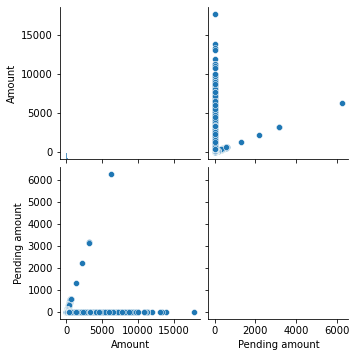

In [73]:
sns.pairplot(i)                   # rimtas išbandymas kompo pajėgumui - 1:46s procesino...

In [ ]:
 Įžvalga:  panašu kad yra tik keletas mokėjimų labai didelėm sumom...

In [ ]:
# kaip IT žmogus negaliu nepasakyti ,kad buvo 'sns.pairplot(i)' vykd.laiku užfiksuotas toks padidėjęs kompo "Power usage"

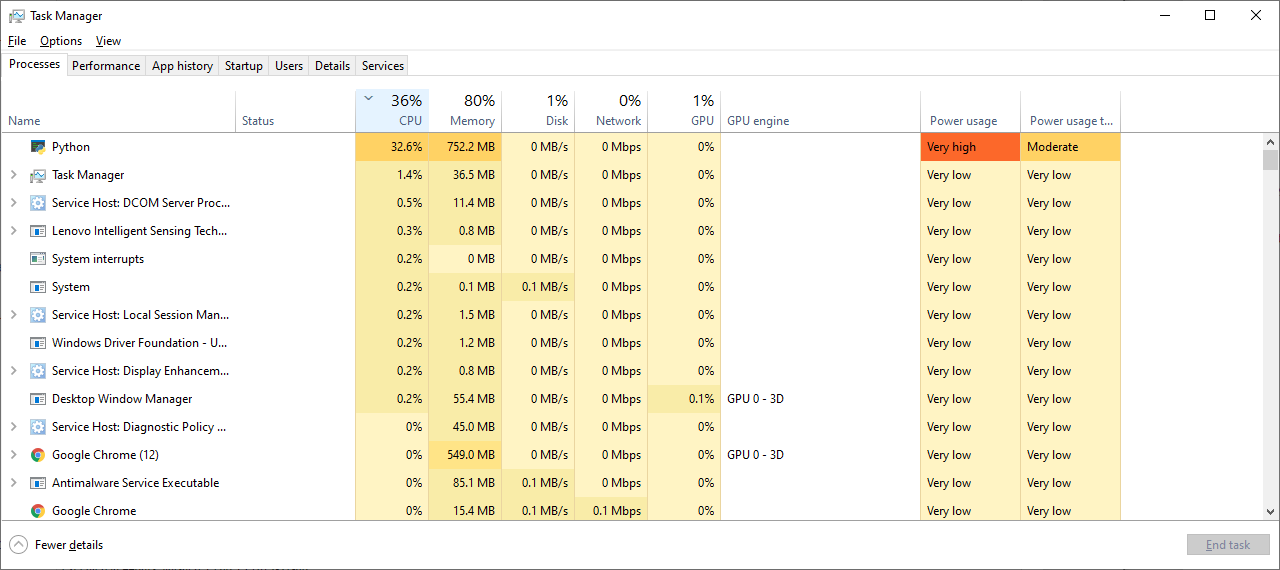

In [ ]:
# Ok. nemažai sužinojau ir... suprantu, kad toliau reikia didesnio ekrano ir interaktyvumo duomenims patyrinėti plačiau
# Einam Tableau

# Duomenų semantikos ir pragmatikos analizė 		            (Tableau)

In [ ]:
# C:\Users\Gedas\DELL\Baigiamasis namu darbas.twb

# Importavimas iš CSV į MySQL su Python pagalba 		        
          

In [ ]:
#                     ( > 1 mln įrašų lentelė apie klientų mokėjimus)  

In [ ]:
# Prieš tai dar pabandžai sukelti >1 mln rows CSV  į MS Excel. Sėkmingai nuskaitė net ~90% turinio ... 
# patvirtinimas kad - "EXCEL IS NOT A DATABASE' 

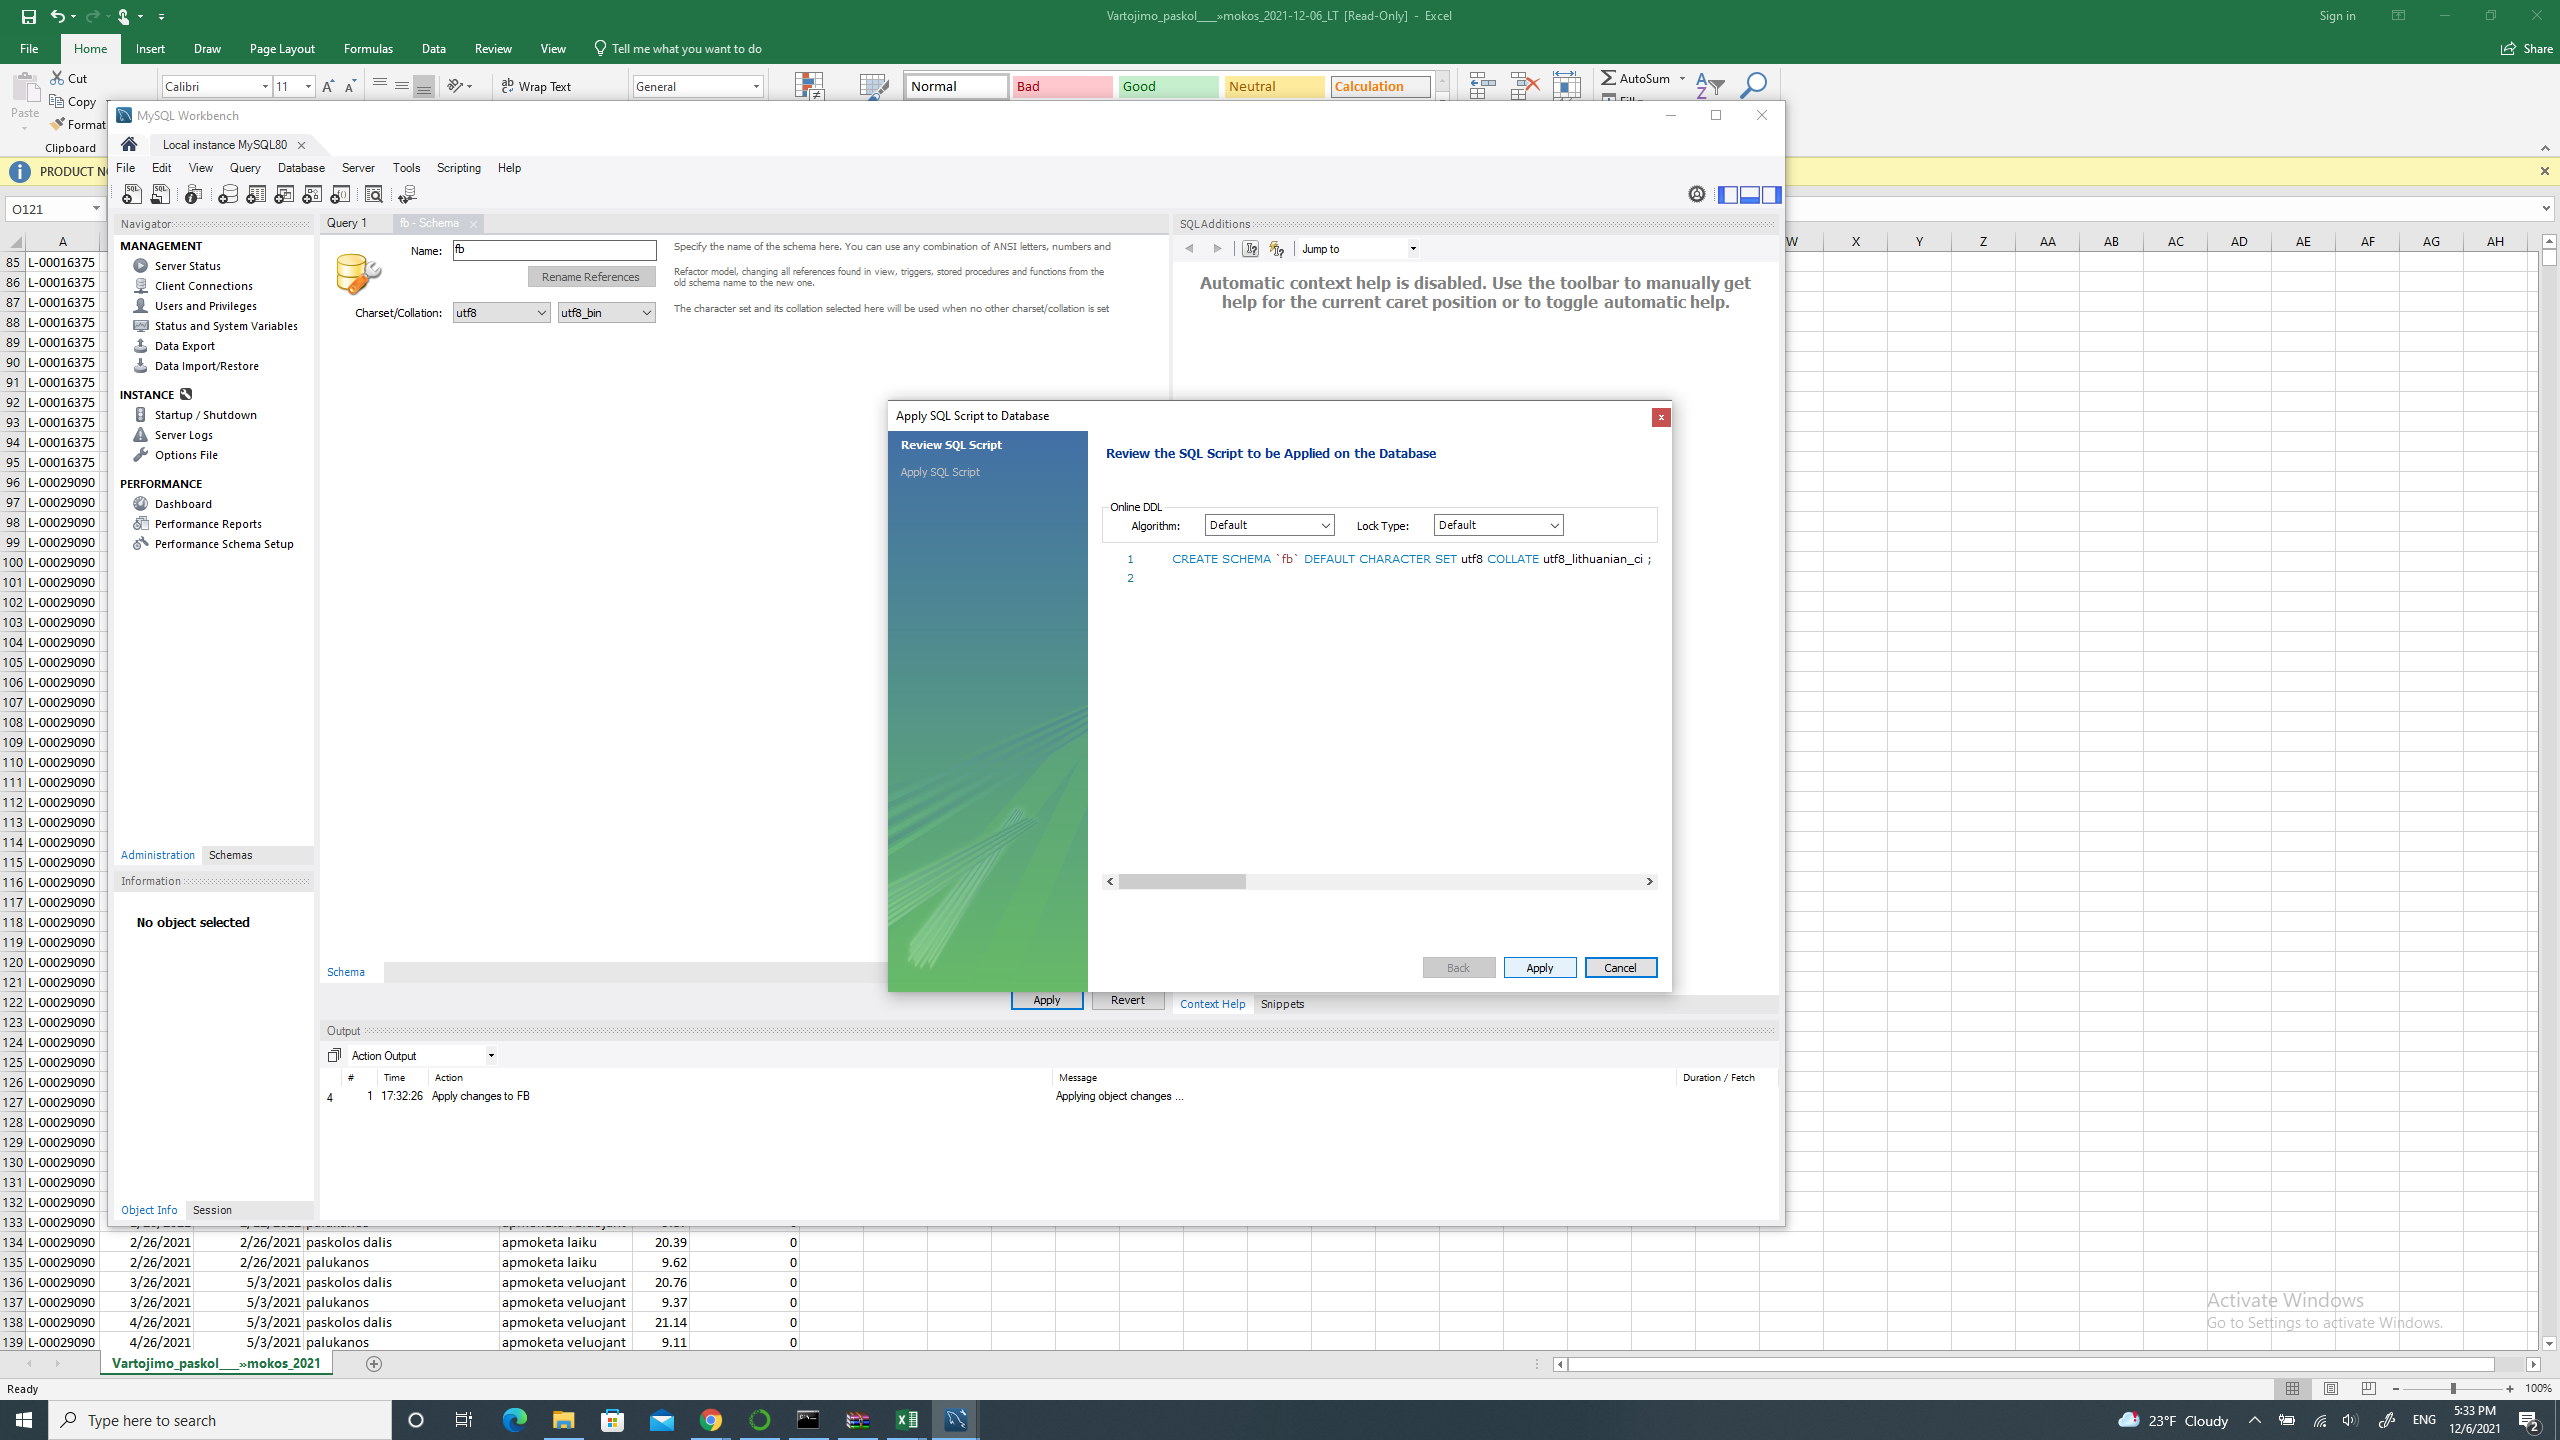
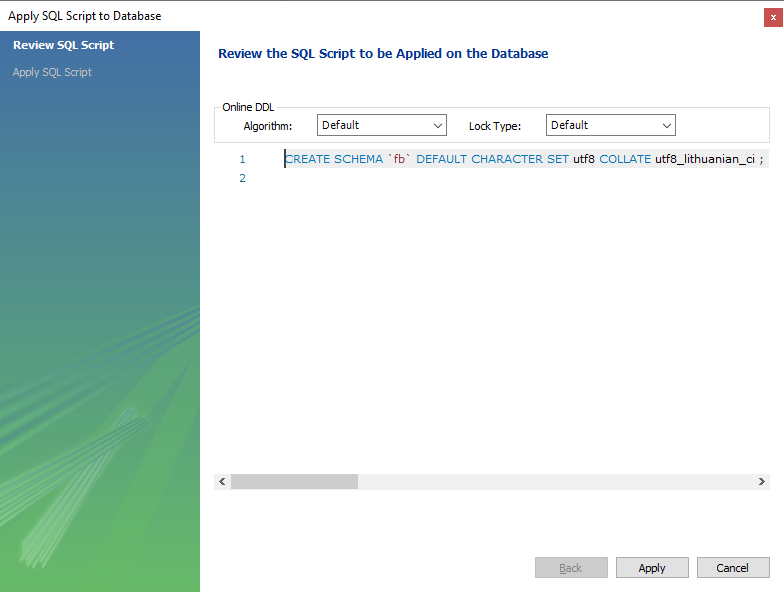
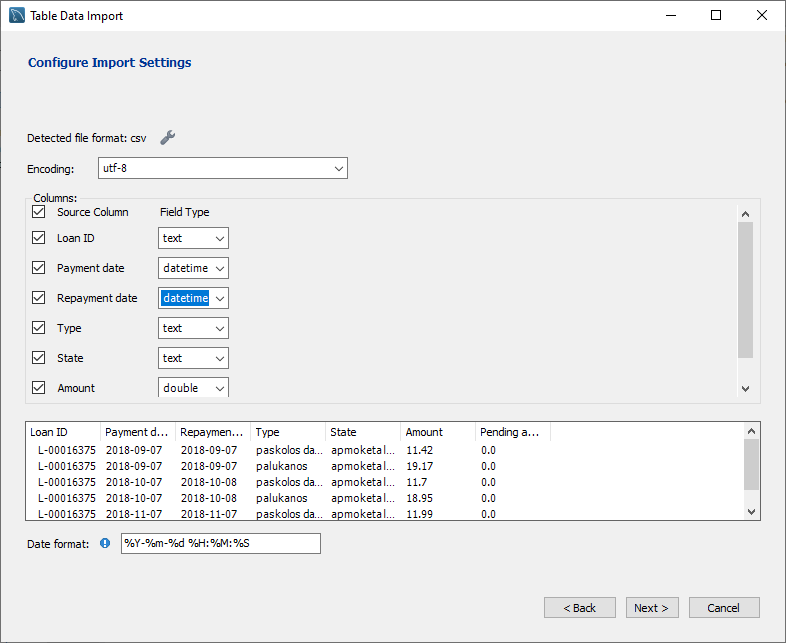
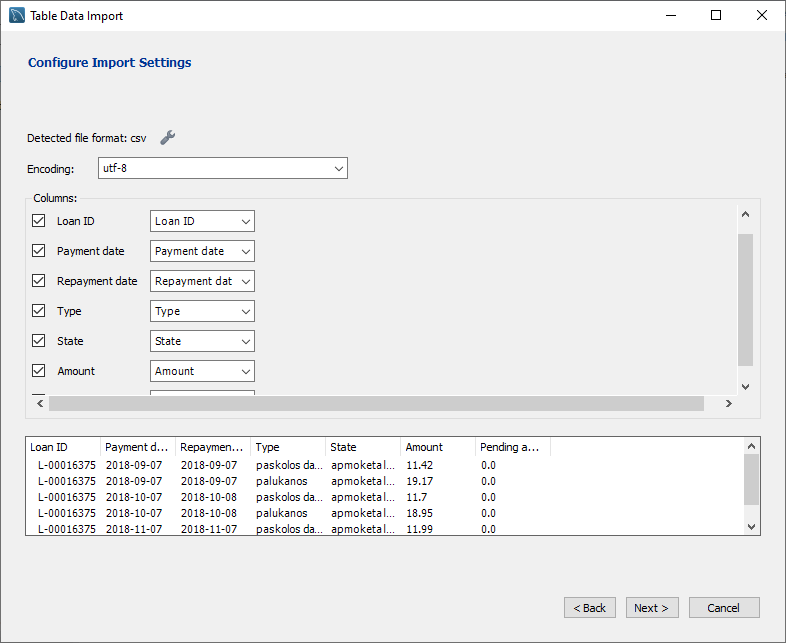

In [ ]:
# Su MySQL Workbench GUI pagalba sukuriau naują SQL duomenų bazės schemą, 
# su WorkBench Data Import Wizard pagalba beveik pavyko... tik labai lėtai : ~3 000 rows / 10 min  ( 1mln / ~6val)
# importavimo eigos progreso lange (Log...) šmėžuoja (nekritinių?) klaidų pranešimai... 
# Negaliu ignoruoti ir rizikuoti 6 val darbo rezultatu... stop. 
# Bandau kitaip... :)

In [124]:
imokos = pd.read_csv('C:\imokos.csv')      # per ~ 3sec Pythion pagalba susikonveruoju CSV i JSON formatą :)


In [127]:
imokos.to_json('C:\\users\\gedas\\imokos.json')    # per ~ 3sec Pythion pagalba susikonveruoju CSV i JSON formatą :)

In [ ]:
# Bet vistiek nepavyksta - kažkodėl MySQL Workbench nieko nepaaiškindamas suimportuoja 0 įrašų... :(
# Bandau kitaip... :)

In [ ]:
# *************** Importavimas iš CSV į MySQL su Python pagalba ***********

In [2]:
import mysql.connector

In [3]:
mydb = mysql.connector.connect(
    host='localhost',
    port='3317',
    user='root',
    password='**************'   #!!!!!!no way!!!!!!!!!!!!!!!!!!!!!!
)
cursor = mydb.cursor()

In [4]:
cursor.execute('SHOW DATABASES') # Pasitikrtiname kokios DB jau yra MySQL serveryje (localhost)
for i in cursor:
    print(i)

('fb',)
('information_schema',)
('mysql',)
('performance_schema',)
('python',)
('sakila',)
('sys',)
('works',)
('world',)


In [117]:
cursor = mydb.cursor()
cursor.execute('CREATE DATABASE python') # kuriame  naują DB nauju pavadinimu 'Python'
cursor.execute('SHOW DATABASES')
for i in cursor:
    print(i)

('fb',)
('information_schema',)
('kursinis',)
('mysql',)
('performance_schema',)
('python',)
('sakila',)
('sys',)
('works',)
('world',)


In [ ]:
# kuriame busimos importuojamos lenteles pavadinimu 'imokos' struktūra "griaučius" SQL klabos sintakses pagalba 
# pirmą kartą iš akies neįvertinau kad stulpelis 'type' varchar(30) bus per trumpas. 
# vėliau pakoregavau ilgio reikšmę iki varchar(50)  

In [10]:

cursor.execute('USE python')
cmd_table = """CREATE TABLE imokos (   
        loan_ID VARCHAR(12) NOT NULL,
        due_date VARCHAR(10) NULL,
        payment_date VARCHAR(10) NULL,
        type VARCHAR(50) NULL,
        status VARCHAR(30) NULL,
        amount DECIMAL(10,2) NULL,
        pend_amount DECIMAL(10,2) NULL);"""
cursor.execute(cmd_table)


In [6]:
cursor.execute('SHOW TABLES')  # lentelė 'imokos' sukurta
for i in cursor:
    print(i[0])

imokos


In [109]:
# FOR FUN, įdėjau savo best effort kodo... t.y. nesekmingi savarankiški pabandymai pagauti ir supakuoti eilutes į ciklą ...

for i in imokos.iloc[:,1:]:
    print(i)

#print(imokos[1:])


Payment date
Repayment date
Type
State
Amount
Pending amount


In [9]:
print(vertes)  # ... kažką tikrinau  02:38 AM... visiškai nepamenu... :)

['L-43893594', '2020-09-22', '2020-09-22', '"sutarties mokescio grazinimas"', '"apmoketa laiku"', '2.90', '0.00\n']


In [ ]:
# ~02:41 AM pasiduodu... tiesiog pasinaudoju ciklo kodu iš paskaitų užrašų... Ačiū labai... :)

In [11]:
cursor = mydb.cursor()
cursor.execute('USE python')
add_row_cmd= """ INSERT INTO imokos VALUES (%s,%s,%s,%s,%s,%s,%s)"""

failas = open('C:\imokos.csv', 'r')
eilutes = failas.readlines()
failas.close()

for i in eilutes[1:]:     # skaitome nuo pirmos eilutes, nes nuline yra stulpeliu pavadinimai
    vertes = i.split(',')
    #print(vertes)
    cursor.execute(add_row_cmd, tuple(vertes))
    mydb.commit()
    
    

In [ ]:
# importavimas paleistas ir suvykdomas per naktį...  - realiai per 1 val ir 14 min

In [ ]:
# dar vienas pastebėjimas Python naudai - kompiuterio apkrovimas Power usage - mažesnis nei SQL Data Import Wizard bandymu

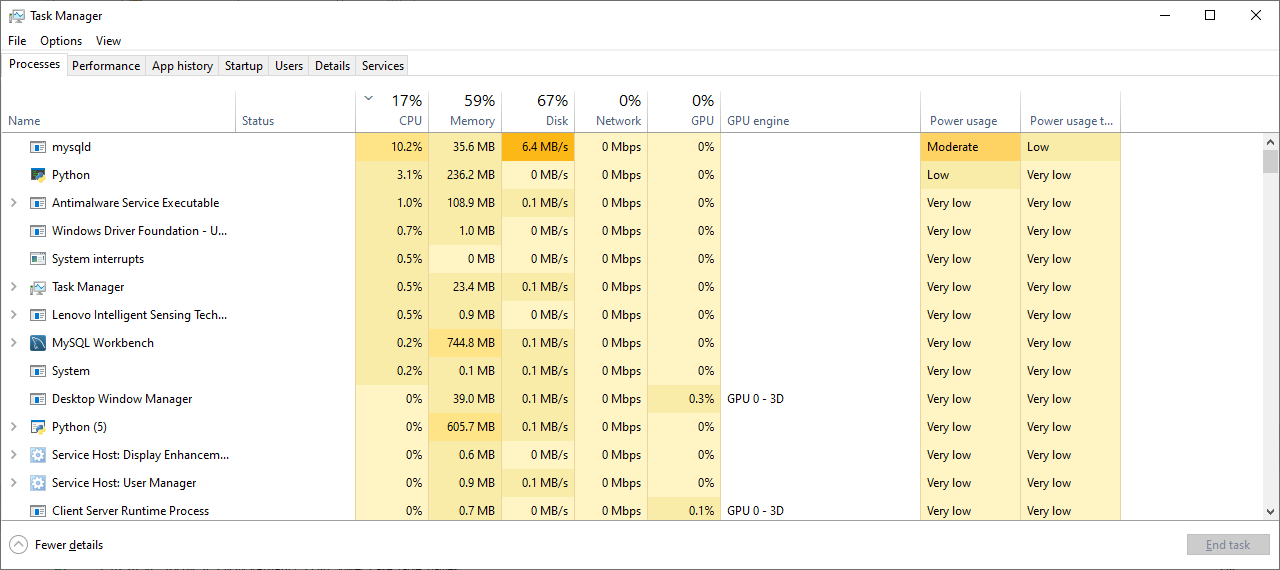


# Duomenų agregavimas SQL'e (group by, count, sum, max, avg)	(MySQL)

In [ ]:
# Noriu atlikti detaliausios duomenų lentelės 'įmokos' įrašų apjungimą ("group by" agregavimą) pagal Loan_ID 
# kad gauti info apie įmokų mokėtojų (klientų) įsipareigojimų vykdymo tvarkingumą, sprendžiant pagal
#  pradelstas apmokėjimo dienas (sum, average, min, max) kiekvienai paskolai (loan_ID)  

In [ ]:
select loan_id, 
sum(amount) as sum_amount,
sum(pend_amount) as sum_pending_a,
datediff(payment_date, due_date) as first_ovrd, 
min(datediff(payment_date, due_date)) as min_ovrd,
max(datediff(payment_date, due_date)) as max_ovrd,
sum(datediff(payment_date, due_date)) as sum_ovrd,
count(*) as counts,
avg(datediff(payment_date, due_date)) as avg_ovrd,
min(due_date) as DD_min,
max(due_date) as DD_max,
min(payment_date) as PD_min,
max(payment_date) as PD_max
from python.imokos 
group by loan_ID;


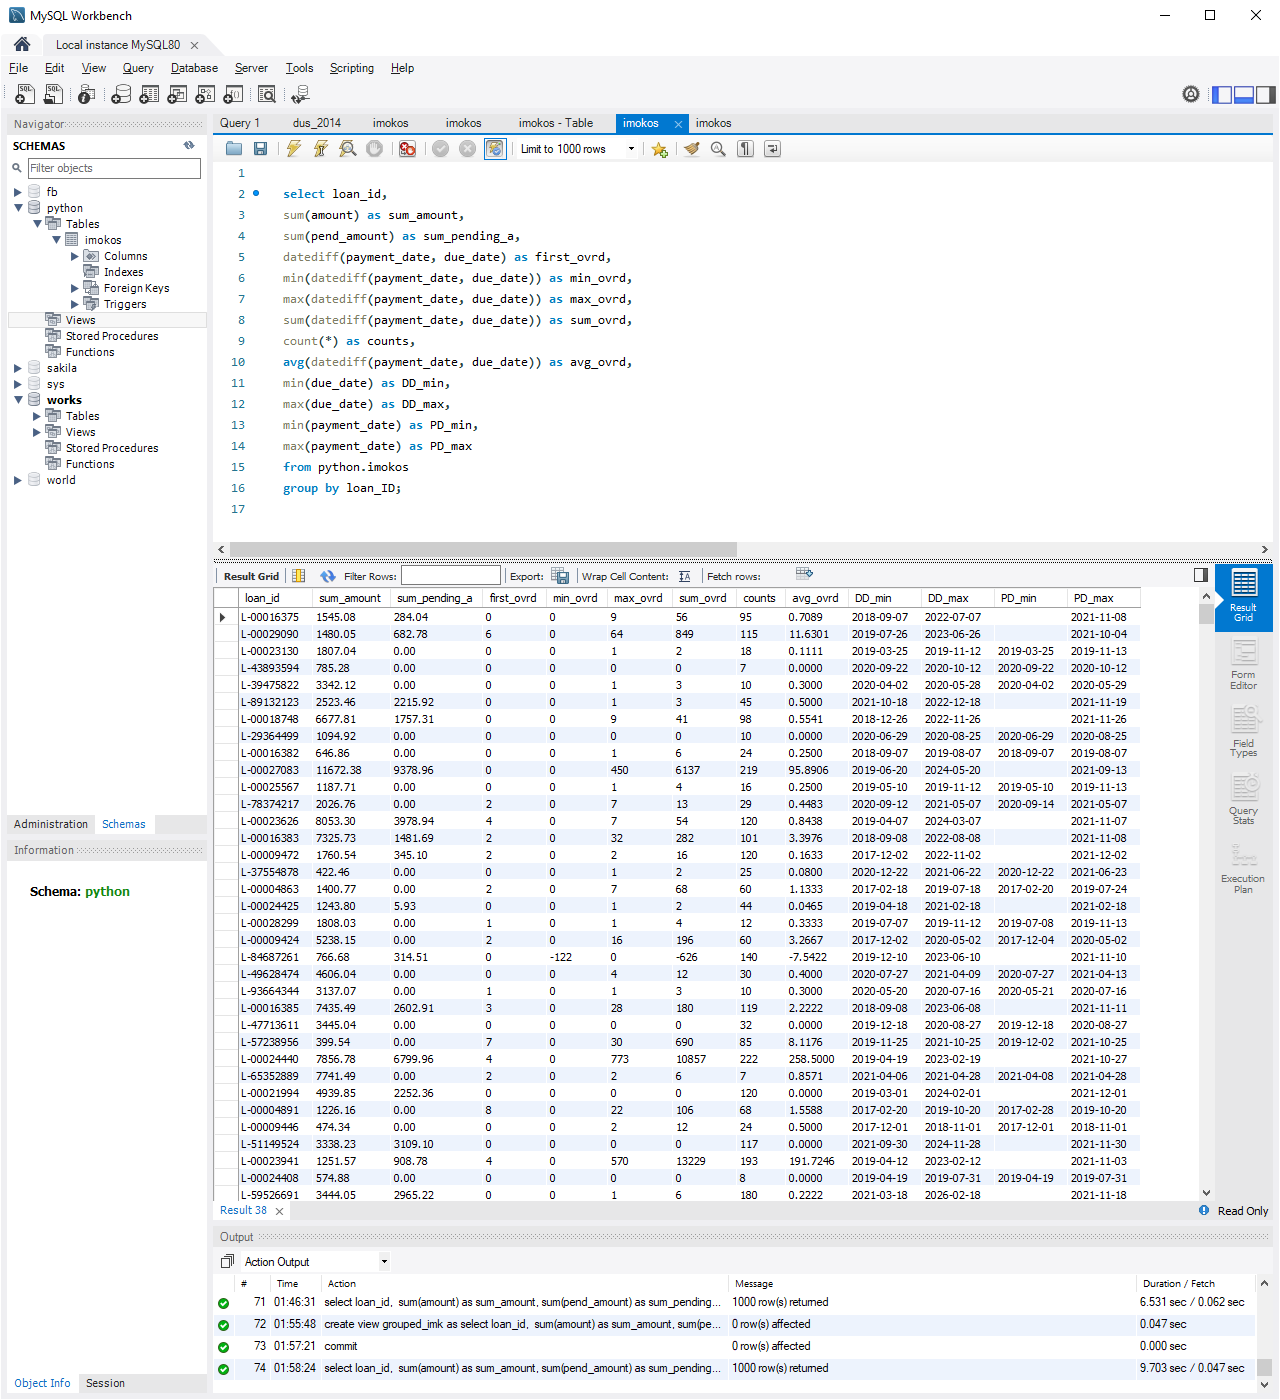


In [ ]:
# MySQL įvykdo agregavimą per per 9.7 s

In [ ]:
# rezultato lentelę (per export data i CSV ) panaudoju tolesnėje analizėje su Tableau ir Python

# Apjungtų duomenų analizė su Tableau 

In [ ]:
# C:\Users\Gedas\DELL\Loans, Defaults by Gender,  MS Age.twb

# Išvados:

 Patvirtinti arba paneigti, kad: 
				          a) "gruodžio, bei sausio mėnesį dažniau grąžinamos skolos"    NEPATVIRTINTA...
				          b) "vyresnės moterys pareigingiau vykdo fin.įsipareigojimus"  PATVIRTINTA
                          c) "vedę vyrai rečiau tampa nemokiais"                        PATVIRTINTA

In [ ]:
(DAR NE) PABAIGA....  o tik <10% nuo max darbo tikslo ir norimo galutinio rezultato 